 - Обучение и тестирование модели YOLOv5 на кастомном датасете.

 - Задача: Детектирование автомобилей.

 - Запуск: Colab.

Датасет лежит в открытом репозитории Wandb, модель автоматически собираем логи.

Logs: https://wandb.ai/volkov-timm/yolov5


In [1]:
!pip install wandb -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 71.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.1/189.1 KB 22.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 7.6 MB/s eta 0:00:00


In [2]:
import wandb
import shutil
run = wandb.init()
artifact = 'volkov-timm/yolov5_car-object-detection/car-object-detection:v0'
artifact = run.use_artifact(artifact, type='dataset')
artifact.download('/content')

shutil.unpack_archive('/content/car-object-detection.zip',
                      '/content')

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: Downloading large artifact car-object-detection:v0, 112.06MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:8.5


In [3]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -qr requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 15305, done.
remote: Total 15305 (delta 0), reused 0 (delta 0), pack-reused 15305
Receiving objects: 100% (15305/15305), 14.13 MiB | 7.52 MiB/s, done.
Resolving deltas: 100% (10501/10501), done.
/content/yolov5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 50.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.9.0 requires jedi>=0.10, which is not installed.
cvxpy 1.3.0 requires setuptools<=64.0.2, but you have setuptools 67.6.0 which is incompatible.


In [4]:
import torch
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Data prepocessing

In [5]:
import pandas as pd
from pandas.core.algorithms import unique
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [6]:
data = pd.read_csv('/content/data/train_solution_bounding_boxes (1).csv')

In [7]:
data.columns

Index(['image', 'xmin', 'ymin', 'xmax', 'ymax'], dtype='object')

In [8]:
def data_split(data_bounb: pd.DataFrame) -> tuple[list[str], list[str], list[str]]:
    """
    создает датасеты для обучения, валидации и теста
    """
    train_dir = "/content/data/training_images/"
    test_dir = "/content/data/testing_images/"

    train_dir = Path(train_dir)
    test_dir = Path(test_dir)

    train_val_files = list(train_dir.rglob('*.jpg'))
    test_files = list(test_dir.rglob('*.jpg'))

    train_files, val_files = train_test_split(
        train_val_files,
        test_size=0.25,
        random_state=12345
    )

    return train_files, val_files, test_files

In [9]:
train_files, val_files, test_files = data_split(data)

In [10]:
# Количество записей и количество размеченных изображений
data.shape[0], len(unique(data['image']))

(559, 355)

In [11]:
def create_yolov5_format(group: pd.DataFrame) -> None:
  """
  Ковертация исходного датасета в Yolov5 format

  group: группа записей по имени изображения

  output: Рядом с изображениями создается текстовый файл
  с данными о боксах и классе в формате yolov5.
  """

  group.reset_index(inplace=True, drop=True)
  path = "/content/data/training_images/"
  
  image = plt.imread(path + group.iloc[0][0])
  im_h, im_w, num_chanels = image.shape
  name_file = group.iloc[0][0][:-4]

  with open(f"{path}{name_file}.txt", 'w+') as f:

    for i in range(group.shape[0]):
      boundb = [0] # class у всех боксов одинаков
      x_center = (group.loc[i]["xmax"] + group.loc[i]["xmin"])/2
      y_center = (group.loc[i]["ymax"] + group.loc[i]["ymin"])/2
      w = group.loc[i]["xmax"] - group.loc[i]["xmin"]
      h = group.loc[i]["ymax"] - group.loc[i]["ymin"]
    
      #Нормализация
      boundb.append(x_center/im_w)
      boundb.append(y_center/im_h)
      boundb.append(w/im_w)
      boundb.append(h/im_h)

      f.write(' '.join(str(_) for _ in boundb))
      f.write("\n")


In [12]:
def path_list(files: list[Path], mode: str) -> None:
  """
  Перемещение файлов в директории images, labels.

  Создание файлов с листингами путей изображений train и val.
  """
  with open(f"/content/data/{mode}.txt", 'w+') as f:
    
    newpath_images = f"/content/data/{mode}/images"
    newpath_labels = f"/content/data/{mode}/labels"

    if not os.path.exists(newpath_images):
      os.makedirs(newpath_images)
      os.makedirs(newpath_labels)

    # разбираем файлы по папкам и создаем листинг файлов для обучения  
    for name_file in files:
      # если файл txt с bounding box создался,
      # то производим копирование, если нет,
      # то обучение/валидацию на нем не производим
      if os.path.isfile(f"{str(name_file)[:-4]}.txt"):
        #image
        shutil.copyfile(str(name_file), newpath_images + f"/{name_file.name}")
        #labels
        shutil.copyfile(f"{str(name_file)[:-4]}.txt",
                        newpath_labels + f"/{name_file.name[:-4]}.txt")
        f.write(newpath_images + f"/{name_file.name}")
        f.write("\n")
  

In [13]:
# create txt files format yolov5
for key, group in data.groupby('image'):
  create_yolov5_format(group)

# создаем необходимые директории и файлы с боксами для обучения и валидации
path_list(train_files, 'train')
path_list(val_files, 'val')

# удаляем изначальную папку training_images
shutil.rmtree("/content/data/training_images")

In [14]:
# создаем конфиг файл для yolo

%%writefile /content/yolov5/data/dataset.yaml
path: /content/data
train: /content/data/train.txt
val: /content/data/val.txt
test:

names:
    0: car

Writing /content/yolov5/data/dataset.yaml


### Train + Logging wandb

In [15]:
!python train.py --img 676 --batch 16 --epochs 25 --data dataset.yaml --weights yolov5m.pt --cache

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
wandb: Currently logged in as: volkov-timm. Use `wandb login --relogin` to force relogin
train: weights=yolov5m.pt, cfg=, data=dataset.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=25, batch_size=16, imgsz=676, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-120-g3e55763 Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)

hyperparam

### Export ONNX

In [16]:
!python export.py --weights /content/yolov5/runs/train/exp/weights/best.pt --img 704 --include onnx

export: data=data/coco128.yaml, weights=['/content/yolov5/runs/train/exp/weights/best.pt'], imgsz=[704], batch_size=1, device=cpu, half=False, inplace=False, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=17, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['onnx']
YOLOv5 🚀 v7.0-120-g3e55763 Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 
Model summary: 212 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs

PyTorch: starting from /content/yolov5/runs/train/exp/weights/best.pt with output shape (1, 30492, 6) (40.2 MB)
requirements: YOLOv5 requirement "onnx>=1.12.0" not found, attempting AutoUpdate...
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is i

### Test

In [17]:
model = torch.hub.load('ultralytics/yolov5',
                       'custom',
                       path='/content/yolov5/runs/train/exp/weights/best.pt',
                       force_reload=True)

/usr/local/lib/python3.9/dist-packages/torch/hub.py:267: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
requirements: YOLOv5 requirement "setuptools>=65.5.1" not found, attempting AutoUpdate...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

requirements: 1 package updated per /root/.cache/torch/hub/u

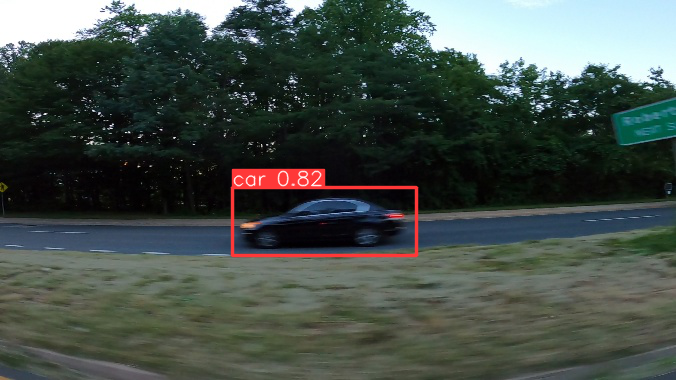

In [18]:
# manual test = )

im = '/content/data/testing_images/vid_5_26620.jpg' 
results = model(im)
results.show()

Детекция изображений на тестовом датасете.

In [19]:
!python detect.py --img 704 --source /content/data/testing_images --weights /content/yolov5/runs/train/exp/weights/best.pt

detect: weights=['/content/yolov5/runs/train/exp/weights/best.pt'], source=/content/data/testing_images, data=data/coco128.yaml, imgsz=[704, 704], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-120-g3e55763 Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 212 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
image 1/175 /content/data/testing_images/vid_5_25100.jpg: 416x704 (no detections), 65.6ms
image 2/175 /content/data/testing_images/vid_5_25120.jpg: 416x704 (no detections), 22.9ms
image 3/175 /content/data/testing_images/vid_5_25140.jpg: 416x704 (no detections), 22.8ms
image 4/175 /content/data/testing_images/vid_5_251